In [995]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import itertools

import json

In [996]:
raw_data = pd.read_csv('data/clean_data.csv')

In [997]:
raw_data.head()

,Yr,Reporting_Entity_RIC_Name,Partner_Entity_RIC_Name,Flow,Reporting_Entity_Continent,Reporting_Entity_Type,Partner_Entity_Continent,Partner_Entity_Type
0,1792,France,Austria,13541271.0,Europe,Country,Europe,Country
1,1792,France,Germany,12300406.0,Europe,Country,Europe,Country
2,1792,France,Netherlands,21864951.0,Europe,Country,Europe,Country
3,1792,France,Portugal,1334107.0,Europe,Country,Europe,Country
4,1792,France,Prussia,2294328.0,Europe,Country,Europe,Country


In [998]:
modu=[]
conductance=[]
coverage=[]
perf=[]

### GTC_Functions

In [999]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

# data importing
raw_data = pd.read_csv('data/clean_data.csv')

class Graph_GT:
    def __init__(self, year, raw_data = raw_data):
        """
        Initialization
        self.df is a pd.dataframe for the given year
        """

        self.year = year
        self.df = raw_data.loc[raw_data['Yr']==year]
 

    def country_list(self):
        """
        raw_date should be a pd.dataframe
        
        """
        country_list = set(list(self.df.Reporting_Entity_RIC_Name)\
                           +list(self.df.Partner_Entity_RIC_Name))
        country_list = sorted(list(country_list))
        return country_list
    
    
    def graph(self):
        """
        creat a nx.graph object(weighted & directed)
        of the trading data for the given year
        """
        
        list_trade = self.df.iloc[:,[1,2,3]].values
#         list_trade_nanremoved = []
#         for row in list_trade:
#             if np.isnan(row[2]) == False:
#                 list_trade_nanremoved +=  [row]
        list_trade = np.array(list_trade)

        #min_max_scaler = preprocessing.MinMaxScaler()
        #
        #list_trade[:,2] = min_max_scaler.fit_transform(list_trade[:,2])       
        #list_trade[:,2] = preprocessing.scale(list_trade[:,2])

#         G = nx.DiGraph()
        G=nx.Graph()
        nodes = []
        for row in list_trade:
            G.add_edge(row[0],row[1])
#             G.add_edge(row[0],row[1],weight=row[2])
            nodes.append(row[0])
            nodes.append(row[1])
        nodes = set(nodes)
        G.add_nodes_from(nodes)
        return G

In [1042]:
year=1860
G = Graph_GT(year = year).graph()
# print nx.is_directed(G)

## Louvain Methode

In [1043]:
import community_louvain

#better with karate_graph() as defined in networkx example.
#erdos renyi don't have true community structure

# dendro = community_louvain.generate_dendrogram(G)
# for level in range(len(dendro)) :
#     print level
# #     print("partition at level", level,"is", community_louvain.partition_at_level(dendro, level))
#     partition=community_louvain.partition_at_level(dendro, level)
#     print community_louvain.modularity(partition,G)

In [1044]:
#first compute the best partition
dict_predict_louvain = community_louvain.best_partition(G)
n_cluster = len(set(dict_predict_louvain.values()))

# print "cluster number "+str(n_cluster)

In [1045]:
partition(dict_predict_louvain)

[{'Bolivia',
  'California (Great Bear Republic)',
  'Chile',
  'Colombia (Gran Colombia)',
  'Ecuador',
  'France',
  'French India',
  'Guadeloupe',
  'Martinique',
  'Peru',
  'Reunion',
  'Senegal',
  'Sierra Leone',
  'St. Pierre and Miquelon',
  'Uruguay'},
 {'Algeria',
  'Ceuta',
  'Gibraltar',
  'Greece',
  'Guatemala',
  'Hamburg',
  'Ionian Is.',
  'Malta',
  'Morocco',
  'Papal States',
  'Puerto Rico',
  'Republic of St. Mark',
  'Spain',
  'Tetuan',
  'Venezuela',
  'Zanzibar'},
 {'Austria',
  'Belgium',
  'Brazil',
  'Denmark',
  'Egypt/United Arab Republic',
  'Finland',
  'Germany',
  'Italy',
  'Kingdom of Sardinia',
  'Luxemburg',
  'Mecklenburg Schwerin',
  'Mexico',
  'Moldavia',
  'Portugal',
  'South Africa',
  'Sweden',
  'Switzerland',
  'Turkey',
  'Viceroyalty of La Plata'},
 {'Australia',
  'Bokhara',
  'Bremen',
  'Cuba',
  'Curacao',
  'Germany (Zollverein)',
  'Hanover',
  'Iran (Persia)',
  'Japan',
  'Khiva',
  'Kyrgyzstan',
  'Lubeck',
  'Netherlands',


In [1046]:
[len(i) for i in partition(dict_predict_louvain)]

[15, 16, 19, 20, 21, 36]

In [1047]:
# community_louvain.modularity(dict_predict_louvain,G)

In [1048]:
# k_community=6
# k_community=n_cluster

## Visualize World Map

In [1049]:
worldmap_data = json.loads(open('data/worldmap.json','r').read())

In [1050]:
code_data = pd.read_csv('data/world_code.csv')
code_data.head()

,RICname,COW_code,iso3n,iso3c
0,Aden,681,NaN,NaN
1,Afghanistan,700,4.0,AFG
2,Alaska,3,NaN,NaN
3,Albania,339,8.0,ALB
4,Aleppo,6525,NaN,NaN


In [1051]:
# dict_predict_louvain[partition_data["RICname"]]
code_data["partition"]=code_data['RICname'].map(dict_predict_louvain)

In [1052]:
partition_data=code_data[code_data["partition"].notnull()]
len(partition_data)

127

In [1053]:
with_iso=partition_data[partition_data["iso3c"].notnull()]
len(with_iso)

64

In [1054]:
partition_data=code_data[code_data["partition"].notnull()]
# partition_data=code_data
partition_data.head()

,RICname,COW_code,iso3n,iso3c,partition
0,Aden,681,NaN,NaN,3.0
5,Algeria,615,12.0,DZA,2.0
7,Andaman and Nicobar Is.,7501,NaN,NaN,3.0
12,Argentina,160,32.0,ARG,0.0
14,Ascension I.,4070,NaN,NaN,3.0


In [1055]:
partition_data_dict = with_iso.to_dict(orient='records')

In [1056]:
partition_data_dict 

[{'COW_code': '615',
  'RICname': 'Algeria',
  'iso3c': 'DZA',
  'iso3n': 12.0,
  'partition': 2.0},
 {'COW_code': '160',
  'RICname': 'Argentina',
  'iso3c': 'ARG',
  'iso3n': 32.0,
  'partition': 0.0},
 {'COW_code': '900',
  'RICname': 'Australia',
  'iso3c': 'AUS',
  'iso3n': 36.0,
  'partition': 4.0},
 {'COW_code': '305',
  'RICname': 'Austria',
  'iso3c': 'AUT',
  'iso3n': 40.0,
  'partition': 5.0},
 {'COW_code': '211',
  'RICname': 'Belgium',
  'iso3c': 'BEL',
  'iso3n': 56.0,
  'partition': 5.0},
 {'COW_code': '80',
  'RICname': 'Belize (British Honduras)',
  'iso3c': 'BLZ',
  'iso3n': 84.0,
  'partition': 0.0},
 {'COW_code': '145',
  'RICname': 'Bolivia',
  'iso3c': 'BOL',
  'iso3n': 68.0,
  'partition': 1.0},
 {'COW_code': '140',
  'RICname': 'Brazil',
  'iso3c': 'BRA',
  'iso3n': 76.0,
  'partition': 5.0},
 {'COW_code': '20',
  'RICname': 'Canada',
  'iso3c': 'CAN',
  'iso3n': 124.0,
  'partition': 0.0},
 {'COW_code': '402',
  'RICname': 'Cape Verde',
  'iso3c': 'CPV',
  'iso

In [1057]:
from IPython.core.display import display, HTML
from string import Template
import json, random

In [1058]:
HTML('''
<script src="lib/d3/d3.min.js"></script>    
<script src="lib/d3/topojson.min.js"></script>
''')

In [1059]:
css_text = '''
path {
        fill: #fff;
        stroke: #000;
        stroke-width:0.5px;
      } 
'''

In [1060]:
html_template = Template('''
<style> $css_text </style>
<div><svg width="960px" height="500px" id="graph-svg"></svg></div>
<script> $js_text </script>
''')
js_text_template = Template(open('js/colormap.js','r').read())
js_text = js_text_template.safe_substitute({'worldmapdata': json.dumps(worldmap_data), 
                                            'partition':json.dumps(partition_data_dict)
                                           })

In [1061]:
display(HTML(html_template.substitute({'css_text': css_text, 'js_text': js_text})))

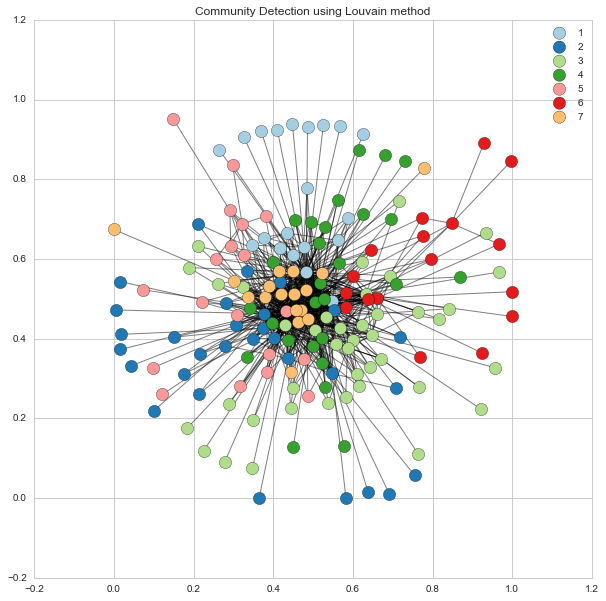

In [914]:
draw_community(dict_predict_louvain,"Louvain")

In [915]:
modu

[0.30103490770081986,
 0.2864506172839506,
 0.2985147309471634,
 0.3780309359125368,
 0.30461037936179985,
 0.28239294982698965,
 0.24554979928513324,
 0.2535806481202416,
 0.19565217391304346,
 0.19052227943765404,
 0.2985147309471634]

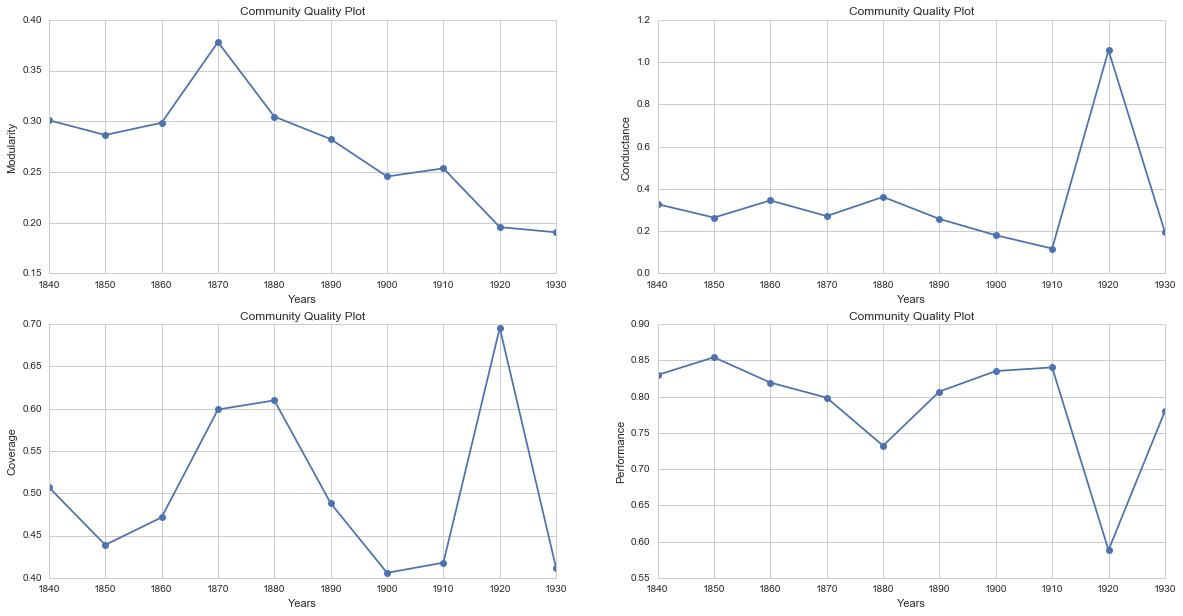

In [855]:
plt.figure(figsize = [20,10])
plt.subplot(221)
plot_quality(modu,"Modularity")
plt.subplot(222)
plot_quality(conductance,"Conductance")
plt.subplot(223)
plot_quality(coverage,"Coverage")
plt.subplot(224)
plot_quality(perf,"Performance")

In [854]:
def plot_quality(method,label):
    sns.set_style("whitegrid")

    plt.plot(range(1840,1940,10),method,marker = 'o')

    plt.xlabel("Years")
    plt.ylabel(label)
    plt.title("Community Quality Plot")

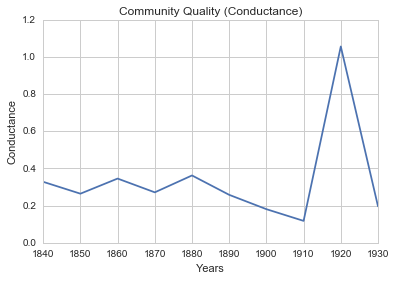

In [852]:
plt.plot(range(1840,1940,10),conductance)
plt.xlabel("Years")
plt.ylabel("Conductance")
plt.title("Community Quality (Conductance)")
plt.show()

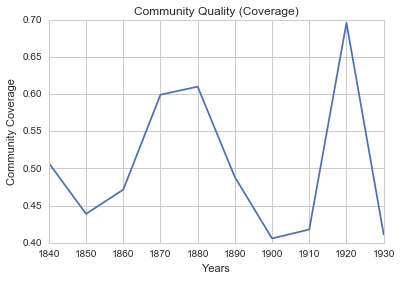

In [835]:
plt.plot(range(1840,1940,10),coverage)
plt.xlabel("Years")
plt.ylabel("Community Coverage")
plt.title("Community Quality (Coverage)")
plt.show()

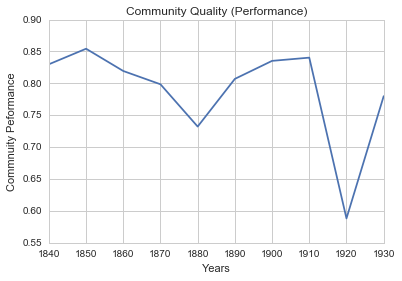

In [836]:
plt.plot(range(1840,1940,10),perf)
plt.xlabel("Years")
plt.ylabel("Commnuity Peformance")
plt.title("Community Quality (Performance)")
plt.show()

## Spectral Clustering

In [487]:
Lap_nom = nx.normalized_laplacian_matrix(G).todense()

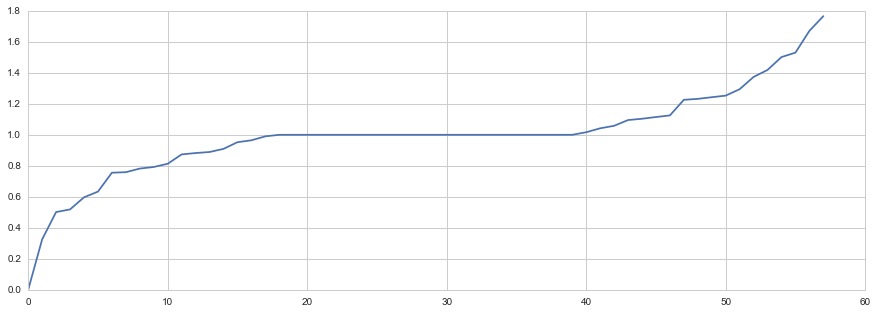

In [488]:
plt.figure(figsize = [15,5])
eig_val, eig_vec = np.linalg.eig(Lap_nom)
plt.plot(sorted(np.linalg.eig(Lap_nom)[0][0:58]))

In [489]:
k = 10
selected_vec = np.zeros([len(eig_val),k])
thr = sorted(eig_val)[k-1]
eig_val, eig_vec = np.linalg.eig(Lap_nom)
ind = 0
for i in range(len(eig_val)):
    if eig_val[i]<=thr:
        selected_vec[:,ind] = np.array(eig_vec)[:,i]
        ind += 1

In [490]:
X = selected_vec

In [491]:
def spec_predict(k_community):
    cluster_km = KMeans(n_clusters = k_community,max_iter = 10000,tol = 0.00000001)
    features_spectre = X
    cluster_km.fit(features_spectre)
    pred = cluster_km.predict(X)

    dict_predict_spec = {}
    for i in range(len(G.nodes())):
        dict_predict_spec.update(
        {   G.nodes()[i] : int(pred[i])
        })
    return dict_predict_spec

# pos = nx.fruchterman_reingold_layout(G)
# colors = ['#1f77b4','#aec7e8','#ff7f0e','#ffbb78','#2ca02c','#98df8a','#d62728'\
#           ,'#ff9896','#9467bd','#c5b0d5','#8c564b','#c49c94','#e377c2','#f7b6d2'\
#           '#7f7f7f','#c7c7c7','#bcbd22','#dbdb8d','#17becf','#9edae5']
# plt.figure(figsize = [10,10])
# count = 0
# for com in set(dict_predict_spec.values()) :
#     count = count + 1
#     list_nodes = [nodes for nodes in dict_predict_spec.keys()
#                                 if dict_predict_spec[nodes] == com]
#     nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150,
#                                 node_color = colors[count],label = count)

# plt.legend()
# nx.draw_networkx_edges(G,pos, alpha=0.5)

# plt.show()

In [492]:
partition_list=[]
for k in range(2,20):
     partition_list.append(spec_predict(k))

In [493]:
modu_list=[community_louvain.modularity(p,G) for p in partition_list]

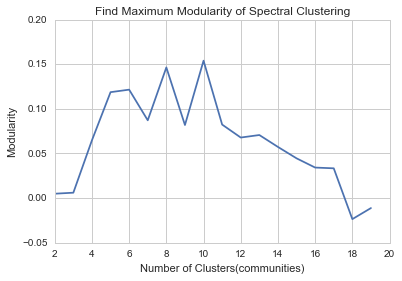

In [494]:
plt.plot(range(2,20),modu_list)
plt.xlabel("Number of Clusters(communities)")
plt.ylabel("Modularity")
plt.title("Find Maximum Modularity of Spectral Clustering")
plt.show()

In [495]:
k_community=10
dict_predict_spec=spec_predict(k_community)

In [496]:
community_louvain.modularity(dict_predict_spec,G)

0.15445646502173038

## Girvan-Newman Clustering

In [497]:
import centrality
def newman_predict(k_community):
    comp = centrality.girvan_newman(G)
    # for communities in itertools.islice(comp, k):
    #     print(tuple(sorted(c) for c in communities)) 
    limited = itertools.takewhile(lambda c: len(c) <= k_community, comp)

    depth=0
    dict_predict_newman = {}
    for communities in limited:
    #     ls += [list(sorted(c) for c in communities)]
    #     print(list(sorted(c) for c in communities))
        depth+=1
        if depth==k_community-1:
            for i in range(len(communities)):
                for d in communities[i]:
                    dict_predict_newman.update({
                            d:i
                        })
    return dict_predict_newman

In [498]:
list_partition=[]
for k in range(2,10):
     list_partition.append(newman_predict(k))

In [499]:
modu_list=[community_louvain.modularity(p,G) for p in list_partition]

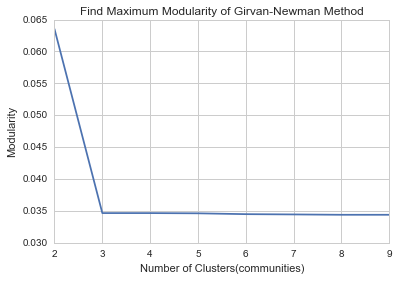

In [500]:
plt.plot(range(2,10),modu_list)
plt.xlabel("Number of Clusters(communities)")
plt.ylabel("Modularity")
plt.title("Find Maximum Modularity of Girvan-Newman Method")
plt.show()

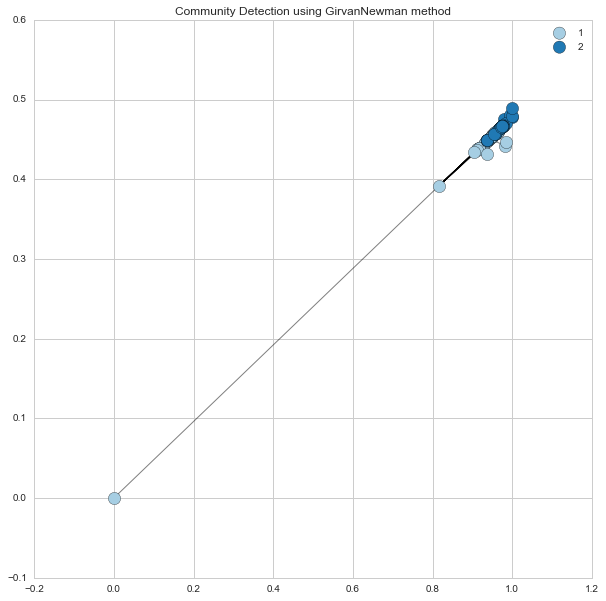

In [501]:
k_community=2
dict_predict_newman=newman_predict(k_community)
draw_community(dict_predict_newman,"GirvanNewman")

In [502]:
community_louvain.modularity(dict_predict_newman,G)

0.06351145645832035

## Clauset-Newman-Moore Clustering

In [172]:
import hrg

dendro=hrg.Dendrogram(G)

In [173]:
dendro.initialize()

{'color_list': ['0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0'],
 'dcoord': [[0.0, 1.0, 1.0, 0.0],
  [1.0, 2.0, 2.0, 0.0],
  [0.0, 1.0, 1.0, 0.0],
  [2.0, 3.0, 3.0, 1.0],
  [0.0, 1.0, 1.0, 0.0],
  [3.0, 4.0, 4.0, 1.0],
  [0.0, 1.0, 1.0, 0.0],
  [1.0, 2.0, 2.0, 0.0],
  [2.0, 3.0, 3.0, 0.0],
  [3.0, 4.0, 4.0, 0.0],
  [4.0, 5.0, 5.0, 4.0],
  [0.0, 1.0, 1.0, 0.0],
  [0.0, 2.0, 2.0, 1.0],
  [2.0, 3.0, 3.0, 0.0],
  [0.0, 1.0, 1.0, 0.0],
  [1.0, 2.0, 2.0, 0.0],
  [3.0, 4.0, 4.0, 2.0],
  [0.0, 1.0, 1.0, 0.0],
  [1.0, 2.0, 2.0, 0.0],
  [0.0, 3.0, 3.0, 2.0],
  [0.0, 4.0, 4.0, 3.0],
  [4.0, 5.0, 5.0, 0.0],
  [5.0, 6.0, 6.0, 0.0],
  [0.0, 1.0, 1.0, 0.0],
  [1.0, 2.0, 2.0, 0.0],
  [0.0, 3.0, 3.0, 2.0],
  [3.0, 4.0, 4.0, 0.0],
  [6.0, 7.0,

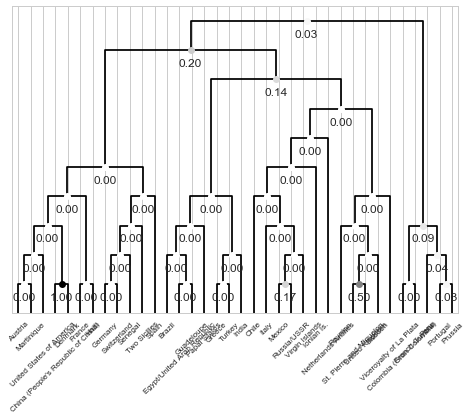

In [175]:
dendro.plot()

## draw community

In [283]:
def draw_community(dict_predict,method):
    pos = nx.fruchterman_reingold_layout(G)
    #pos = nx.spring_layout(G)
    
    plt.figure(figsize = [10,10])
    count = 0
    
    palette = itertools.cycle(sns.color_palette("Paired",10))
    for com in set(dict_predict.values()) :
        count = count + 1
        list_nodes = [nodes for nodes in dict_predict.keys()
                                    if dict_predict[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150,
                                    node_color=next(palette),label = count)
    plt.legend()
    nx.draw_networkx_edges(G,pos, alpha=0.5)
    plt.title("Community Detection using "+method+" method" )
    plt.show()

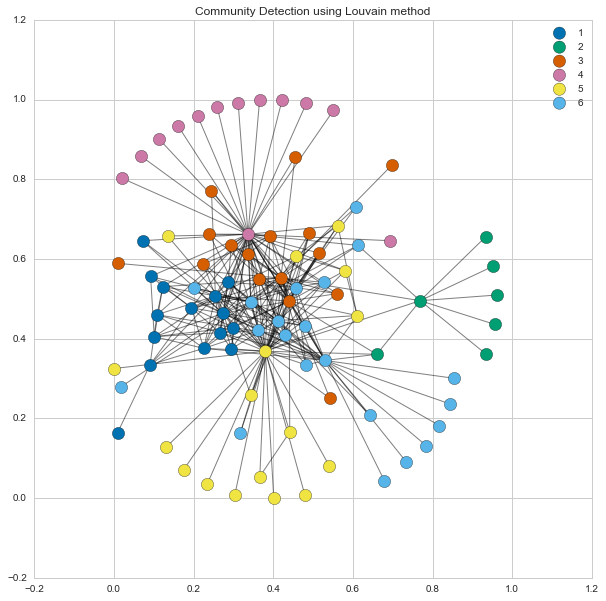

In [205]:
draw_community(dict_predict_louvain,"Louvain")
draw_community(dict_predict_spec,"Spectral")
draw_community(dict_predict_newman,"GirvanNewman")

In [563]:
def partition(dict_predict):
    n_cluster = len(set(dict_predict.values()))
    partition = [[] for i in range(n_cluster)]
    for i in range(n_cluster):
        for d in dict_predict:
            if(dict_predict[d])==i:
                partition[i].append(d)
    partition=[set(ls) for ls in partition]
    return sorted(partition,key=len)

In [258]:
d = {"Number of nodes": [len(i) for i in partition(dict_predict_louvain)]+[len(i) for i in partition(dict_predict_spec)]+\
     [len(i) for i in partition(dict_predict_newman)],\

     "Method": ['Louvain' for i in partition(dict_predict_newman)]+['Spectral' for i in partition(dict_predict_newman)]+\
     ['GirvanNewman' for i in partition(dict_predict_newman)],\
     
     'Partition': list(range(len(partition(dict_predict_louvain))))+list(range(len(partition(dict_predict_louvain))))+\
     list(range(len(partition(dict_predict_louvain))))
     }
df=pd.DataFrame(data=d)
df

,Method,Number of nodes,Partition
0,Louvain,5,0
1,Louvain,12,1
2,Louvain,14,2
3,Louvain,14,3
4,Louvain,15,4
5,Louvain,19,5
6,Spectral,2,0
7,Spectral,7,1
8,Spectral,10,2
9,Spectral,13,3


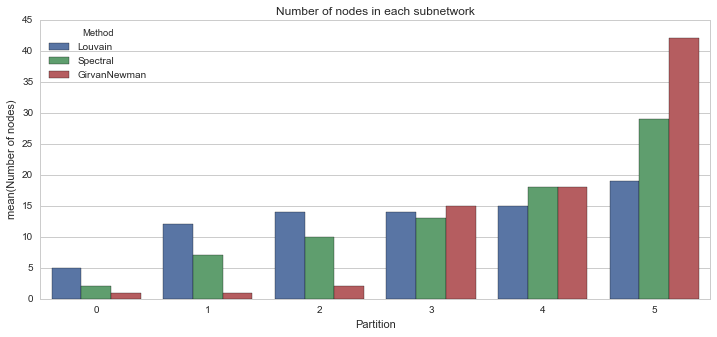

In [260]:
plt.figure(figsize = [12,5])
palette = sns.color_palette()
sns.barplot(x = 'Partition', y = 'Number of nodes', hue = 'Method',palette=palette, data = df )
plt.title("Number of nodes in each subnetwork")

## Calculation of Modulartiy

In [507]:
import community_quality
# import minors

In [455]:
# modu_1905 = [community_louvain.modularity(dict_predict_louvain, G),\
#                    community_louvain.modularity(dict_predict_spec, G),\
#                    community_louvain.modularity(dict_predict_newman, G)]

## Calculation of Conductance 

In [555]:
import community_conductance as cond

In [556]:
def get_cluster_nodes_from_dict(cluster_index,dict_predict):
    """
    return the nodes of a certain cluster
    """
    return {k:v for (k,v) in dict_predict.items() if v==cluster_index}.keys()

In [557]:
def conductance_by_index(index_1, index_2,dict_predict = dict_predict_louvain, G = G):
    return cond.conductance(G,get_cluster_nodes_from_dict(index_1,dict_predict),get_cluster_nodes_from_dict(index_2,dict_predict))

In [558]:
def normalized_conductance(dict_predict,G=G):
    """
    Calculate nomarlized conductance:
    total conductance/number of couples
    """
#     list_index = list(set(dict_predict.values()))
    list_index=set(dict_predict.values())
    conductance_tol = 0
    
    for i in list_index:
        for j in list_index:
            if i != j:
                conductance_tol += conductance_by_index(i,j,dict_predict,G)
    return conductance_tol/float(len(list_index)*(len(list_index)-1))/2.

In [559]:
# cond_1905 = [normalized_conductance(dict_predict_louvain),normalized_conductance(dict_predict_spec),\
#  normalized_conductance(dict_predict_newman)]
normalized_conductance(dict_predict_louvain)

0.32785498814910585

## Community Quality

In [465]:
# cov_1905=[community_quality.coverage(G,partition(dict_predict_louvain)),\
#                community_quality.coverage(G,partition(dict_predict_spec)),\
#                community_quality.coverage(G,partition(dict_predict_newman))]

In [466]:
# intra=community_quality.intra_community_edges(G,partition)
# print intra

# inter=community_quality.inter_community_edges(G,partition)
# print inter

In [467]:
# is_partition=community_quality.is_partition(G,partition)
# is_partition
# perf_1905=[community_quality.performance(G,partition(dict_predict_louvain)),\
#                community_quality.performance(G,partition(dict_predict_spec)),\
#                community_quality.performance(G,partition(dict_predict_newman))]

## Plot Community Quanlity

In [468]:
modu=np.array([modu_1840,modu_1880,modu_1905]).transpose()
cond=np.array([cond_1840,cond_1880,cond_1905]).transpose()
coverage=np.array([cov_1840,cov_1880,cov_1905]).transpose()
performance=np.array([perf_1840,perf_1880,perf_1905]).transpose()

In [469]:
def plot_quality(list,method):
    list_year = [1840,1880,1905]
    sns.set_style("white")

    plt.plot(range(3),list[0], color = 'darkred',label = "Louvain",marker = 'o',alpha=0.5)
    plt.plot(range(3),list[1], color = 'darkgreen',label = "Spectral",marker = 'o',alpha=0.5)
    plt.plot(range(3),list[2], color = 'darkblue',label = "GirvanNewman",marker = 'o',alpha=0.5)
    plt.xticks(range(3),list_year)

    plot_margin = 0.25

    x0, x1, y0, y1 = plt.axis()
    plt.axis((x0 - plot_margin,
              x1 + plot_margin,
              y0 ,y1+plot_margin))
    plt.xlabel("year")
    plt.title("Comparison of Community "+method+"(weighted)")
    plt.legend()

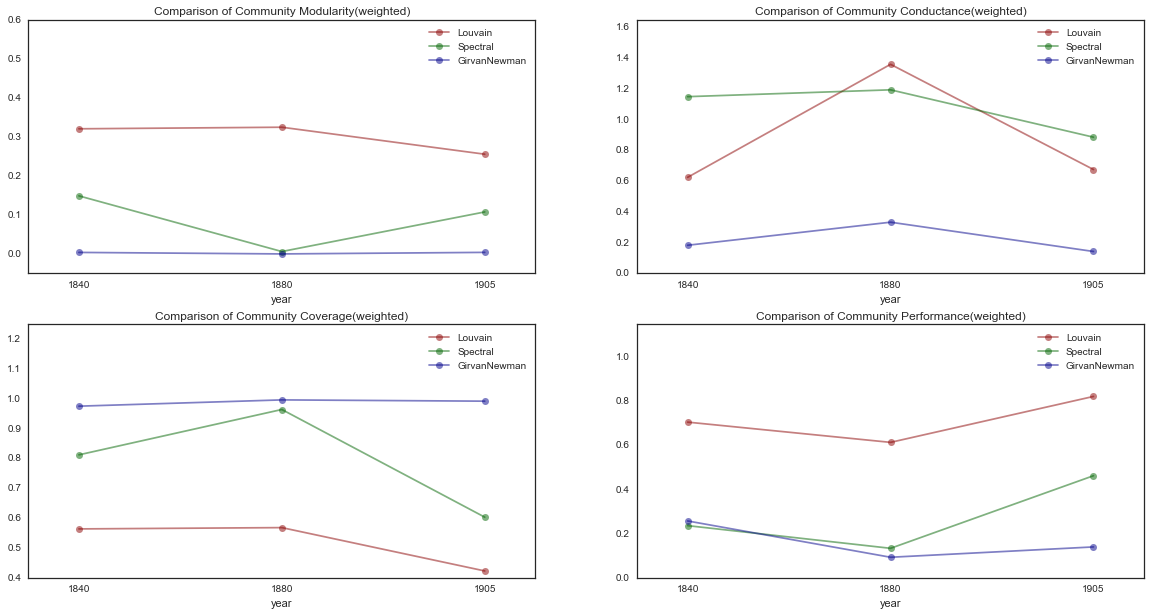

In [470]:
plt.figure(figsize = [20,10])
plt.subplot(221)
plot_quality(modu,"Modularity")
plt.subplot(222)
plot_quality(cond,"Conductance")
plt.subplot(223)
plot_quality(coverage,"Coverage")
plt.subplot(224)
plot_quality(performance,"Performance")

In [205]:
# from igraph import *
# compare_communities(partition(dict_predict_louvain),partition(dict_predict_spec))

ValueError: iterable must yield integers

## Overlapping clustering

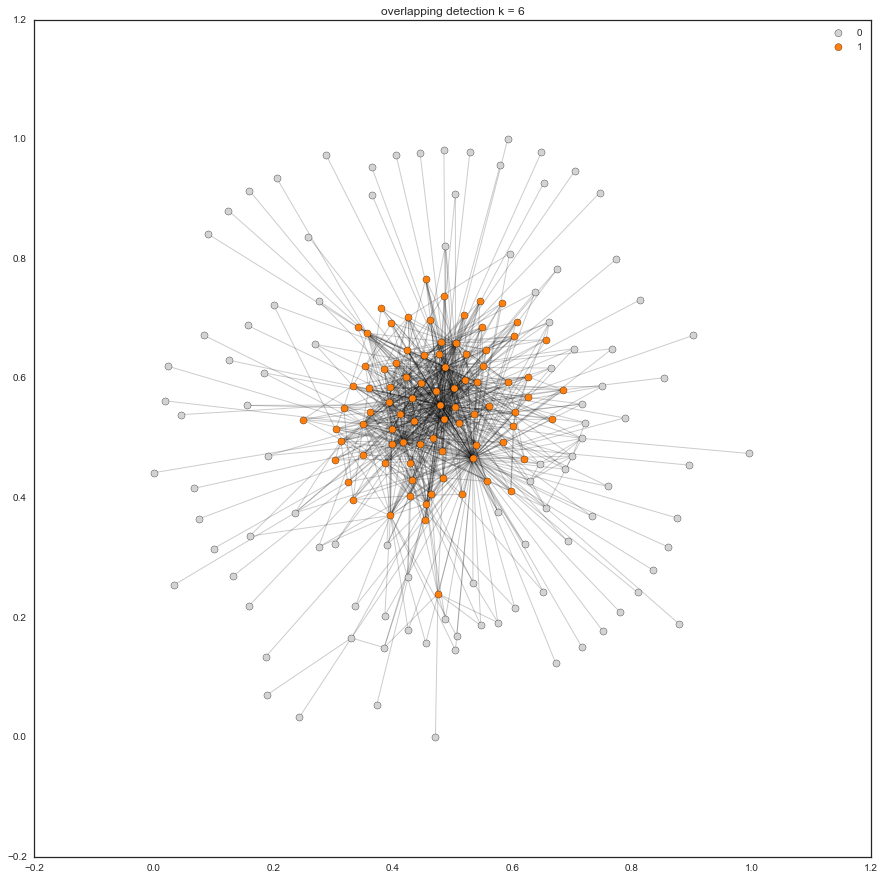

{'Aden': 1,
 'Afghanistan': 0,
 'Alaska': 0,
 'Algeria': 1,
 'Andorra': 0,
 'Angola': 0,
 'Argentina': 1,
 'Ascension I.': 0,
 'Australia': 1,
 'Austria': 0,
 'Austria-Hungary': 1,
 'Azores (Western Isles)': 0,
 'Baden': 0,
 'Bahamas': 0,
 'Bahrain': 0,
 'Banjermassin (Dutch Borneo)': 0,
 'Barbados': 1,
 'Belgium': 1,
 'Belize (British Honduras)': 0,
 'Bermuda': 1,
 'Bolivia': 1,
 'Bosnia': 0,
 'Brazil': 1,
 'Bremen': 0,
 'British Columbia': 0,
 'British Somaliland (Somaliland Republic)': 0,
 'British Virgin Is.': 1,
 'Brunei': 0,
 'Buenos Aires': 0,
 'Bulgaria': 1,
 'Burma (Myanmar)': 0,
 'Canada': 1,
 'Canary Is.': 1,
 'Cape Colony': 1,
 'Cape Verde': 0,
 'Ceuta': 0,
 'Chafarinas': 0,
 'Chile': 1,
 "China (People's Republic of China)": 1,
 'Cochin China': 0,
 'Colombia (Gran Colombia)': 1,
 'Costa Rica': 1,
 'Crete': 0,
 'Cuba': 1,
 'Curacao': 0,
 'Cyprus': 1,
 'Denmark': 1,
 'Djibouti (Afar and Issas) (French Somaliland)': 0,
 'Dominican Republic (Santo Domingo)': 0,
 'Ecuador': 1,


In [471]:
from collections import defaultdict
import networkx as nx

__all__ = ['k_clique_communities']


def k_clique_communities(G, k, cliques=None):
    """Find k-clique communities in graph using the percolation method.

    A k-clique community is the union of all cliques of size k that
    can be reached through adjacent (sharing k-1 nodes) k-cliques.

    Parameters
    ----------
    G : NetworkX graph

    k : int
       Size of smallest clique

    cliques: list or generator       
       Precomputed cliques (use networkx.find_cliques(G))

    Returns
    -------
    Yields sets of nodes, one for each k-clique community.

    Examples
    --------
    >>> G = nx.complete_graph(5)
    >>> K5 = nx.convert_node_labels_to_integers(G,first_label=2)
    >>> G.add_edges_from(K5.edges())
    >>> c = list(nx.k_clique_communities(G, 4))
    >>> list(c[0])
    [0, 1, 2, 3, 4, 5, 6]
    >>> list(nx.k_clique_communities(G, 6))
    []

    References
    ----------
    .. [1] Gergely Palla, Imre Derényi, Illés Farkas1, and Tamás Vicsek,
       Uncovering the overlapping community structure of complex networks 
       in nature and society Nature 435, 814-818, 2005,
       doi:10.1038/nature03607
    """
    if k < 2:
        raise nx.NetworkXError("k=%d, k must be greater than 1."%k)
    if cliques is None:
        cliques = nx.find_cliques(G)
    cliques = [frozenset(c) for c in cliques if len(c) >= k]

    # First index which nodes are in which cliques
    membership_dict = defaultdict(list)
    for clique in cliques:
        for node in clique:
            membership_dict[node].append(clique)

    # For each clique, see which adjacent cliques percolate
    perc_graph = nx.Graph()
    perc_graph.add_nodes_from(cliques)
    for clique in cliques:
        for adj_clique in _get_adjacent_cliques(clique, membership_dict):
            if len(clique.intersection(adj_clique)) >= (k - 1):
                perc_graph.add_edge(clique, adj_clique)

    # Connected components of clique graph with perc edges
    # are the percolated cliques
    for component in nx.connected_components(perc_graph):
        yield(frozenset.union(*component))

def _get_adjacent_cliques(clique, membership_dict):
    adjacent_cliques = set()
    for n in clique:
        for adj_clique in membership_dict[n]:
            if clique != adj_clique:
                adjacent_cliques.add(adj_clique)
    return adjacent_cliques

k_clique_coef = 6


overlap_list = []

for i in range(len(list(nx.k_clique_communities(G,k_clique_coef)))):
    
    overlap_list += [list(list(nx.k_clique_communities(G,k_clique_coef))[i])]

pred = []
for j in range(len(list(nx.k_clique_communities(G,k_clique_coef)))):
    for i in range(len(G.nodes())):
    
        if G.nodes()[i] in overlap_list[j]:
            pred += [j+1]
        else:
            pred +=[0]
    

dict_predict = {}
for i in range(len(G.nodes())):
    dict_predict.update(
    { G.nodes()[i] : int(pred[i])
        })

plt.figure(figsize = [15,15])

pos = nx.fruchterman_reingold_layout(G)
#pos = nx.spring_layout(G)
count = 0


# colors = ['#1f77b4','#aec7e8','#ff7f0e','#ffbb78','#2ca02c','#98df8a','#d62728'\
#           ,'#ff9896','#9467bd','#c5b0d5','#8c564b','#c49c94','#e377c2','#f7b6d2'\
#           '#7f7f7f','#c7c7c7','#bcbd22','#dbdb8d','#17becf','#9edae5']
colors = ['lightgrey', '#ff7f0e','#ffbb78','#2ca02c','#98df8a','#d62728'\
           ,'#ff9896','#9467bd','#c5b0d5','#8c564b','#c49c94','#e377c2','#f7b6d2'\
           '#7f7f7f','#c7c7c7','#bcbd22','#dbdb8d','#17becf','#9edae5']
for com in set(dict_predict.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in dict_predict.keys()
                                if dict_predict[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50,
                                node_color = colors[count-1],label = count-1)

plt.legend()
nx.draw_networkx_edges(G,pos, alpha=0.2)
plt.title('overlapping detection k = '+ str(k_clique_coef))
plt.show()

dict_predict